In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt





In [2]:
prefixs = [ "LoRA_Trigger", "noLoRA_Trigger", "training"]


In [ ]:
trigger_prompt = " "
object_prompt = "a photo sks of chair in front of the TV"

In [5]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="sd_xl_base_1.0.safetensors",
    LoRA="greenchair_webui.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [6]:
print(config.short_object_prompt)

a photo sks of chair


In [11]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"


In [ ]:
# load experiment data
experiment_data = {}

with open('experiment_data.pkl', 'rb') as f:
    experiment_data['lora'] = pickle.load(f)
with open('experiment_data.pkl', 'rb') as f:
    experiment_data['nolora'] = pickle.load(f)
    

In [ ]:
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace'])
print(experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace'])

[[[[[-1.1992e+01  5.3438e+00 -7.0703e+00 ... -7.2461e-01 -1.5908e+00
     -5.9375e+00]
    [ 6.5312e+00 -2.1391e+01 -5.0195e+00 ...  3.7012e+00 -1.5672e+01
      3.5234e+00]
    [-8.2891e+00 -8.4297e+00 -5.3164e+00 ... -6.7461e+00  6.6250e+00
     -4.5898e+00]
    ...
    [-6.8164e-01 -1.2559e+00 -1.8027e+00 ... -1.8750e+00 -3.4727e+00
     -1.1297e+01]
    [-1.8730e+00 -3.4297e+00 -6.1328e-01 ... -2.4023e+00  9.7266e-01
      8.3984e-01]
    [-7.2383e+00 -9.1719e+00 -8.9453e+00 ... -2.4375e+00 -8.1094e+00
      2.2812e+00]]

   [[ 1.9266e+01 -2.2031e+00 -6.9727e+00 ... -7.6367e+00 -8.1484e+00
      1.9434e+00]
    [ 2.5762e+00 -1.0938e+01  9.9609e-01 ... -8.2715e-01 -7.1992e+00
     -6.3750e+00]
    [-3.5156e+00 -6.7930e+00 -5.9570e+00 ... -1.1562e+01 -9.8047e-01
     -6.5312e+00]
    ...
    [-3.8320e+00 -3.5508e+00 -1.0797e+01 ... -7.1797e+00 -7.1562e+00
     -4.2109e+00]
    [-6.5547e+00 -1.0695e+01 -4.0859e+00 ... -1.3953e+01 -6.9258e+00
     -9.4688e+00]
    [ 4.3594e+00 -5.0117e

In [ ]:
import numpy as np

def compute_global_stats(experiment_data):
    """
    計算三個 key 的全域 mean 與 var，
    回傳格式：{ 'latent': {'mean':…, 'var':…}, … }
    """
    stats = {}
    keys = ["latent", "image", "hspace"]
    for key in keys:
        flat = []
        print(f"Processing key: {key}")
        for base in experiment_data.keys():
            print(f"Processing base: {base}")
            for prompts in experiment_data[base].values():
                for images in prompts.values():
                    for fields in images.values():
                        # 檢查資料是否包含 NaN 或 Inf
                        invalid_mask = np.isnan(fields[key]) | np.isinf(fields[key])
                        if np.any(invalid_mask):
                            print(f"Filtered invalid data for key '{key}': {fields[key][invalid_mask]}")
                        
                        # 過濾掉無效數據（如 NaN 或 Inf）
                        valid_data = fields[key][~invalid_mask]
                        if valid_data.size > 0:
                            # 限制數值範圍，避免極端值
                            valid_data = np.clip(valid_data, -1e6, 1e6)
                            flat.append(valid_data.flatten())
                        else:
                            print(f"Warning: No valid data for key '{key}' in current fields.")
        if flat:
            concat = np.concatenate(flat)
            stats[key] = {
                "mean": concat.mean(),
                "var": concat.var(ddof=0)
            }
            # 檢查是否出現 inf，若出現則設為 0
            if np.isinf(stats[key]["var"]):
                print(f"Warning: Variance for key '{key}' is inf. Setting variance to 0.")
                stats[key]["var"] = 0
            print(f"Key: {key}, Mean: {stats[key]['mean']}, Variance: {stats[key]['var']}")
        else:
            stats[key] = {
                "mean": 0,
                "var": 0
            }
            print(f"Warning: No data found for key '{key}'. Setting mean and variance to 0.")
    return stats

def normalize_experiment_data_zscore(experiment_data):
    """
    用 compute_global_stats 回傳的 mean/var，
    對每張圖的三個 key 做 Z-Score 標準化。
    """
    stats = compute_global_stats(experiment_data)
    print(stats)
    normalized = {}
    for base in experiment_data.keys():
        normalized[base] = {}
        for prefix, prompts in experiment_data[base].items():
            normalized[base][prefix] = {}
            for prompt, images in prompts.items():
                normalized[base][prefix][prompt] = {}
                for image_name, fields in images.items():
                    normalized[base][prefix][prompt][image_name] = {}
                    for key, arr in fields.items():
                        mu = stats[key]["mean"]
                        var = stats[key]["var"]
                        if var > 0:
                            # 避免溢位，限制數值範圍
                            zscore = (arr - mu) / np.sqrt(var)
                            zscore = np.clip(zscore, -1e6, 1e6)  # 限制範圍避免極端值
                            normalized[base][prefix][prompt][image_name][key] = zscore
                        else:
                            # 若 var=0（所有值相同），僅去中心化
                            normalized[base][prefix][prompt][image_name][key] = arr - mu
                            print(f"Warning: {prefix} {prompt} {image_name} {key} has zero variance, only centering applied.")
    return normalized

# 使用修正後的 normalize 函式
experiment_data = normalize_experiment_data_zscore(experiment_data)

Processing key: latent
Key: latent, Mean: 0.26389801502227783, Variance: 1979.794677734375
Processing key: image
Key: image, Mean: 118.01651970836836, Variance: 8990.225909799283
Processing key: hspace
Key: hspace, Mean: 0.18123631179332733, Variance: 29.36363983154297
{'latent': {'mean': 0.26389802, 'var': 1979.7947}, 'image': {'mean': 118.01651970836836, 'var': 8990.225909799283}, 'hspace': {'mean': 0.18123631, 'var': 29.36364}}


In [ ]:
print(experiment_data.keys())
print(experiment_data['lora']['LoRA_Trigger'].keys())
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt].keys())
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png'].keys())
print(len(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace']))
print(len(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['image']))
print(len(experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['latent']))

dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])
dict_keys(['a photo sks of chair'])
dict_keys(['LoRA_Trigger_0.png', 'LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])
dict_keys(['hspace', 'image', 'latent'])
19
19
19


In [ ]:
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace'])

[[[[[-2.24609375e+00  9.53125000e-01 -1.33789062e+00 ...
     -1.67236328e-01 -3.27148438e-01 -1.12890625e+00]
    [ 1.17187500e+00 -3.98242188e+00 -9.59472656e-01 ...
      6.49414062e-01 -2.92578125e+00  6.16699219e-01]
    [-1.56347656e+00 -1.58886719e+00 -1.01464844e+00 ...
     -1.27832031e+00  1.18945312e+00 -8.80371094e-01]
    ...
    [-1.59301758e-01 -2.65380859e-01 -3.66210938e-01 ...
     -3.79638672e-01 -6.74316406e-01 -2.11914062e+00]
    [-3.79150391e-01 -6.66503906e-01 -1.46606445e-01 ...
     -4.76806641e-01  1.46118164e-01  1.21582031e-01]
    [-1.36914062e+00 -1.72558594e+00 -1.68457031e+00 ...
     -4.83398438e-01 -1.53027344e+00  3.87451172e-01]]

   [[ 3.52148438e+00 -4.40185547e-01 -1.32031250e+00 ...
     -1.44238281e+00 -1.53710938e+00  3.25195312e-01]
    [ 4.41894531e-01 -2.05273438e+00  1.50390625e-01 ...
     -1.86157227e-01 -1.36230469e+00 -1.20996094e+00]
    [-6.82617188e-01 -1.28710938e+00 -1.13281250e+00 ...
     -2.16796875e+00 -2.14477539e-01 -1.23828

In [21]:
import numpy as np

def euclidean(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.any(np.isnan(p1)) or np.any(np.isnan(p2)) or np.any(np.isinf(p1)) or np.any(np.isinf(p2)):
        print("Invalid input detected:", p1, p2)
        return float('inf')
    return np.linalg.norm(p1 - p2)


def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [ ]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for base in experiment_data.keys():
        analysis_data[base] = {}
        for prefix in experiment_data[base].keys():
            analysis_data[base][prefix] = {}
            for prompt in experiment_data[base][prefix].keys():
                analysis_data[base][prefix][prompt] = {}
                first_image_name = ""
                for image_name in experiment_data[base][prefix][prompt].keys():
                    if first_image_name == "":
                        first_image_name = image_name
                        continue
                    analysis_data[base][prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                    for key in ["latent", "image", "hspace"]:
                        for i in range(len(experiment_data[base][prefix][prompt][image_name][key])):
                            distance = distance_func(experiment_data[base][prefix][prompt][image_name][key][i], experiment_data[base][prefix][prompt][first_image_name][key][i])
                            analysis_data[base][prefix][prompt][image_name][key].append(distance)
    return analysis_data


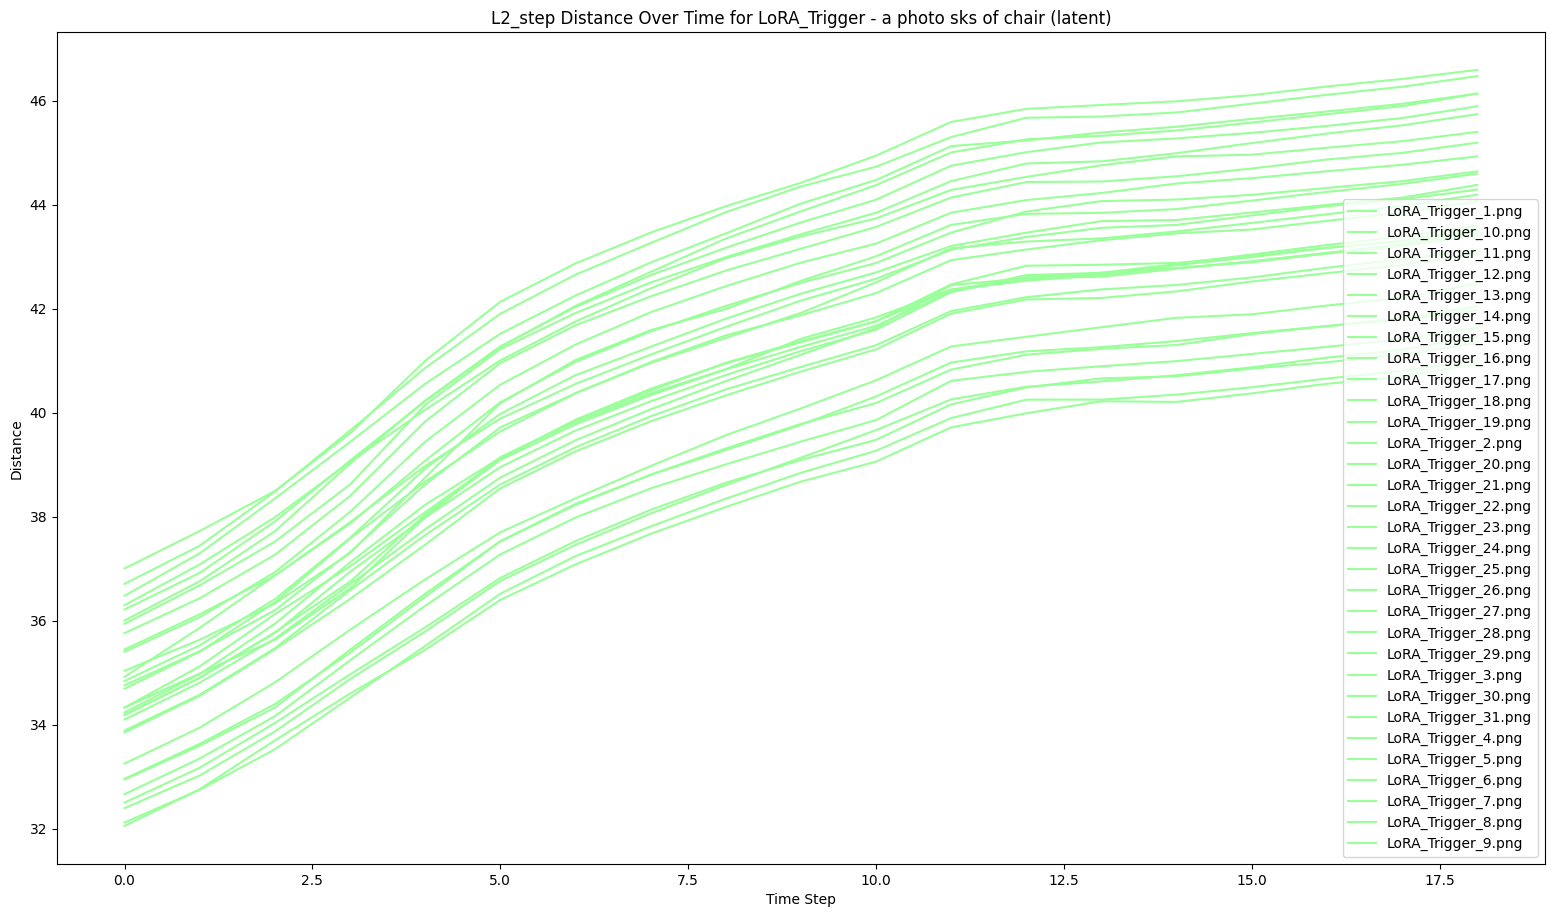

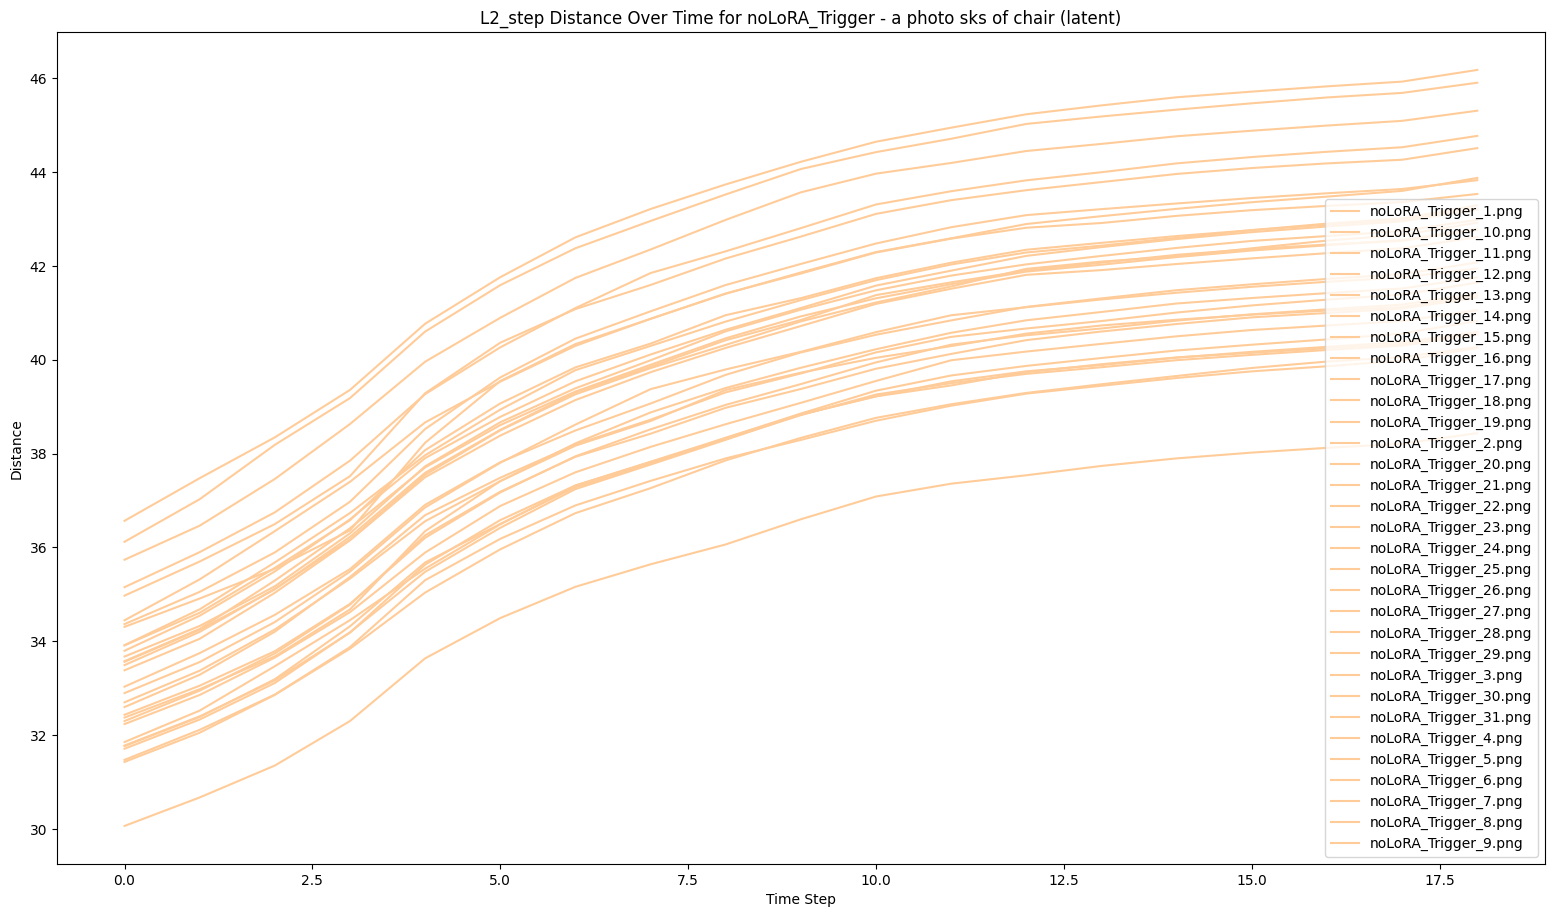

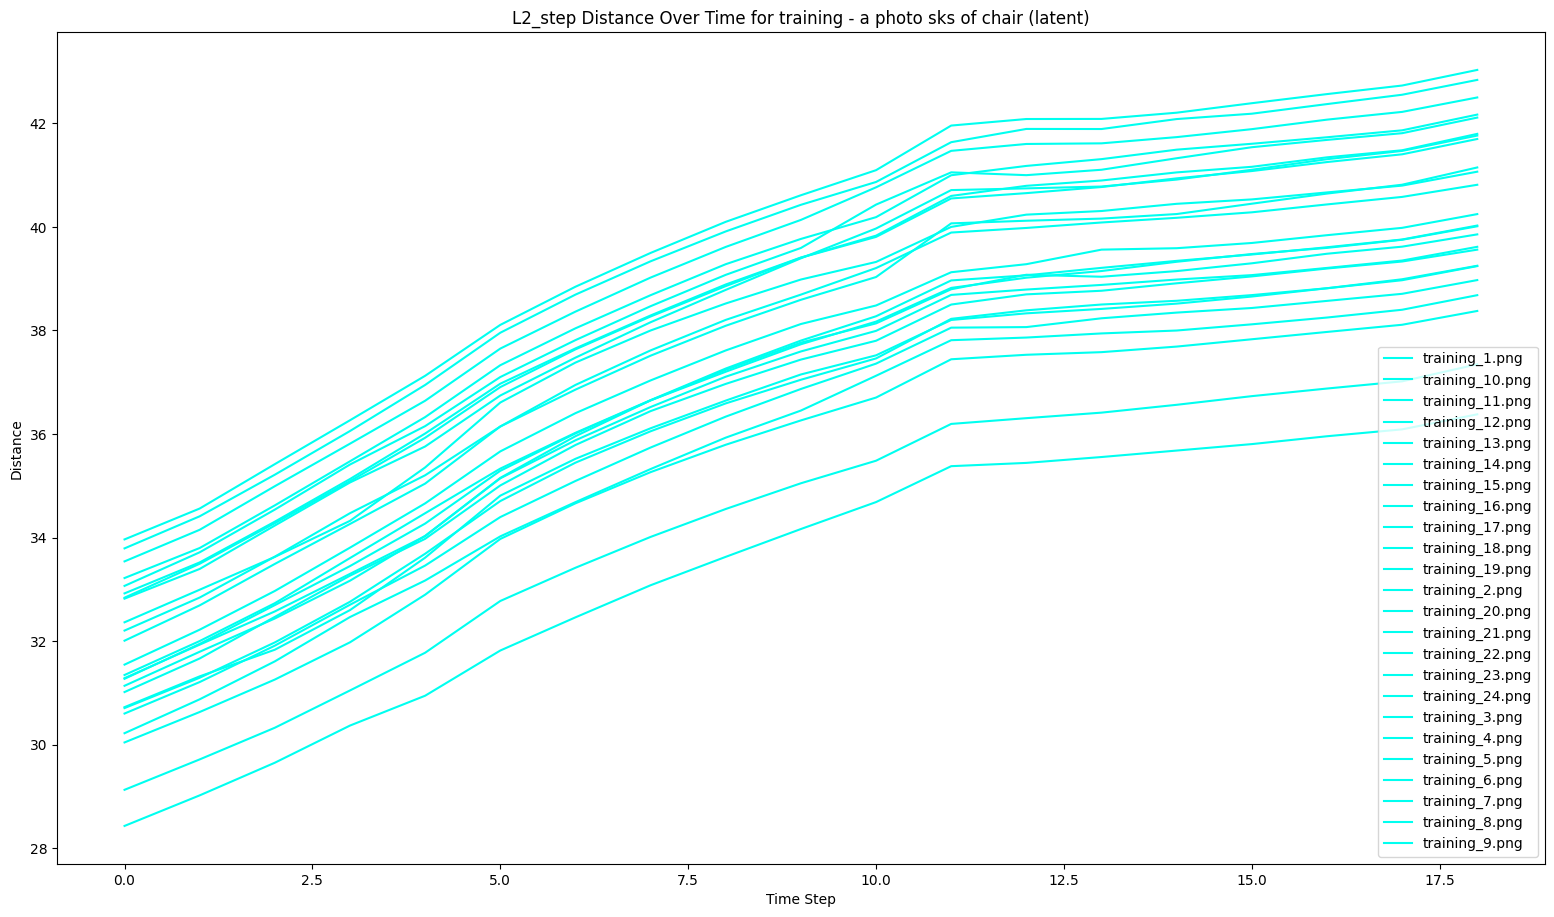

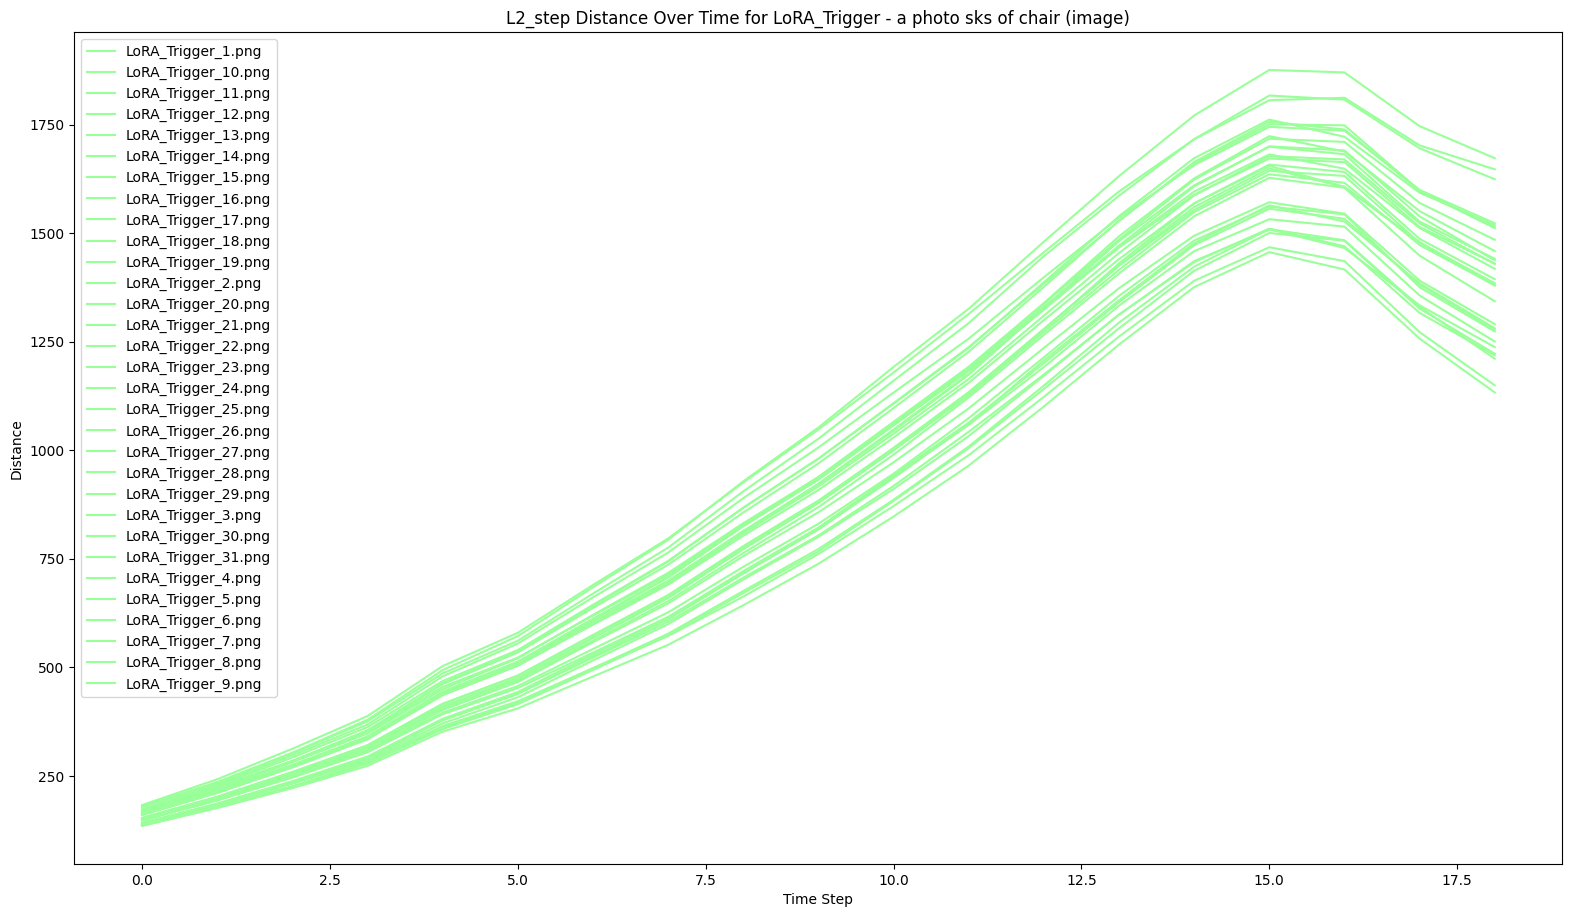

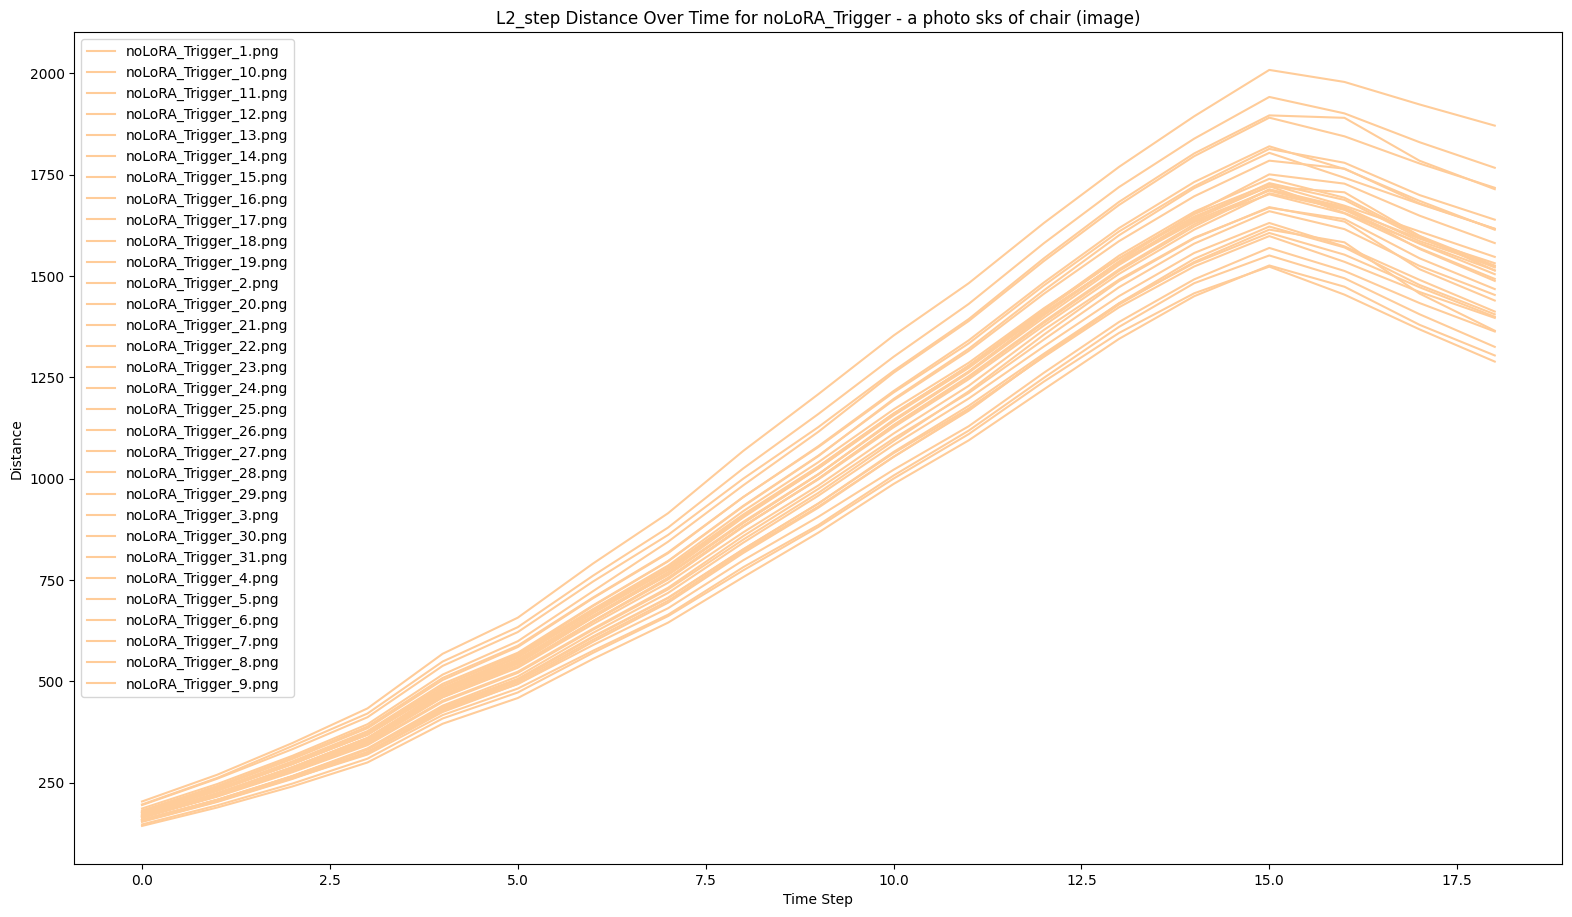

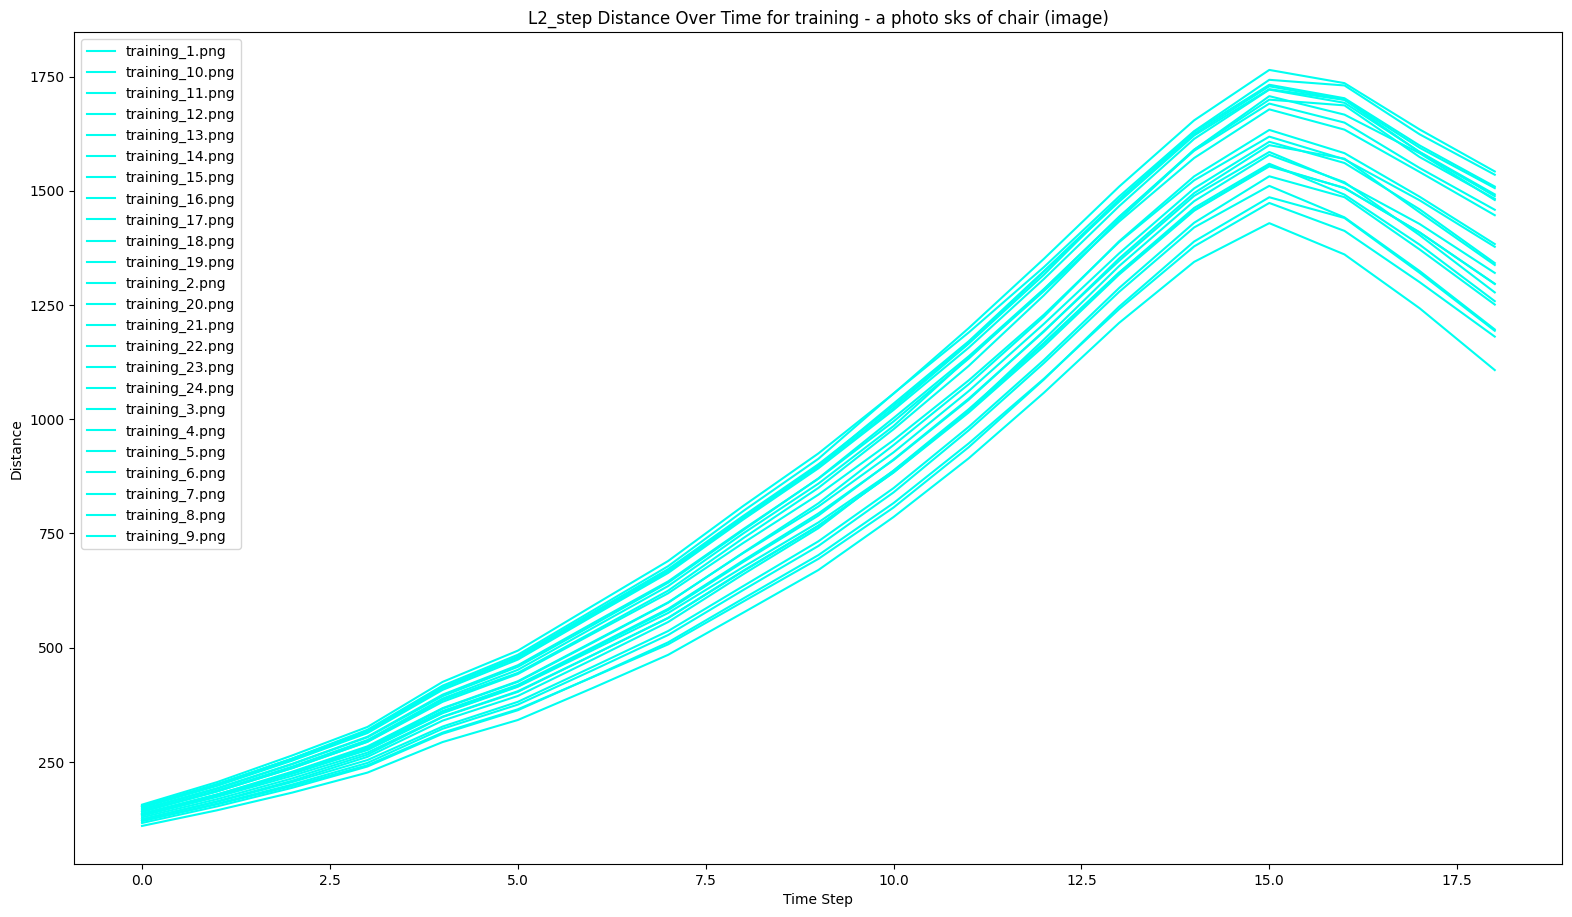

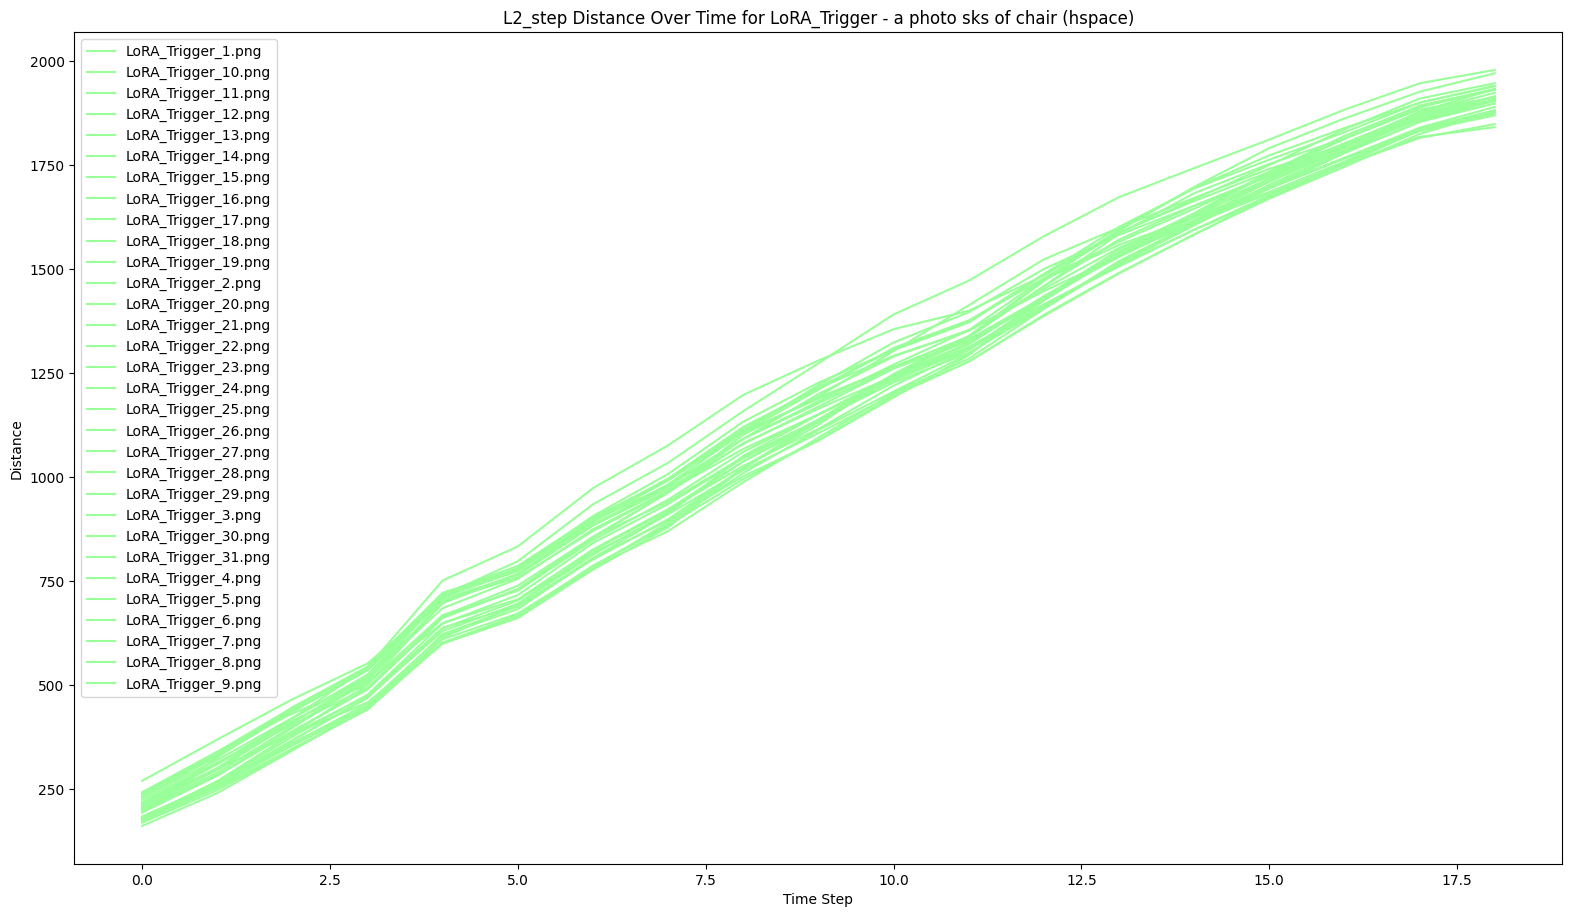

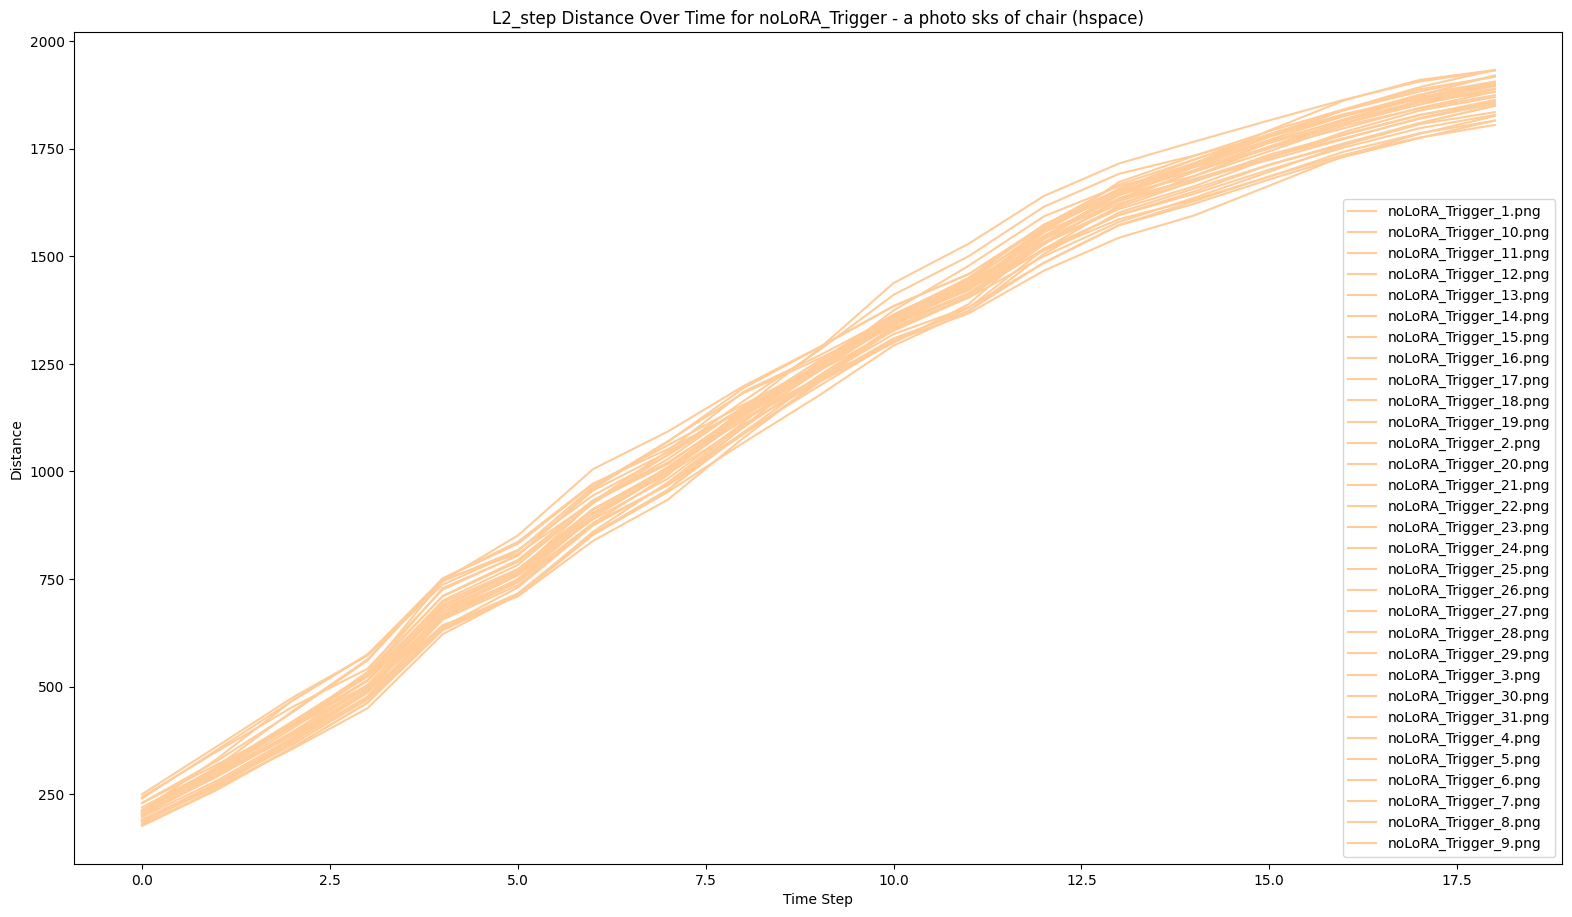

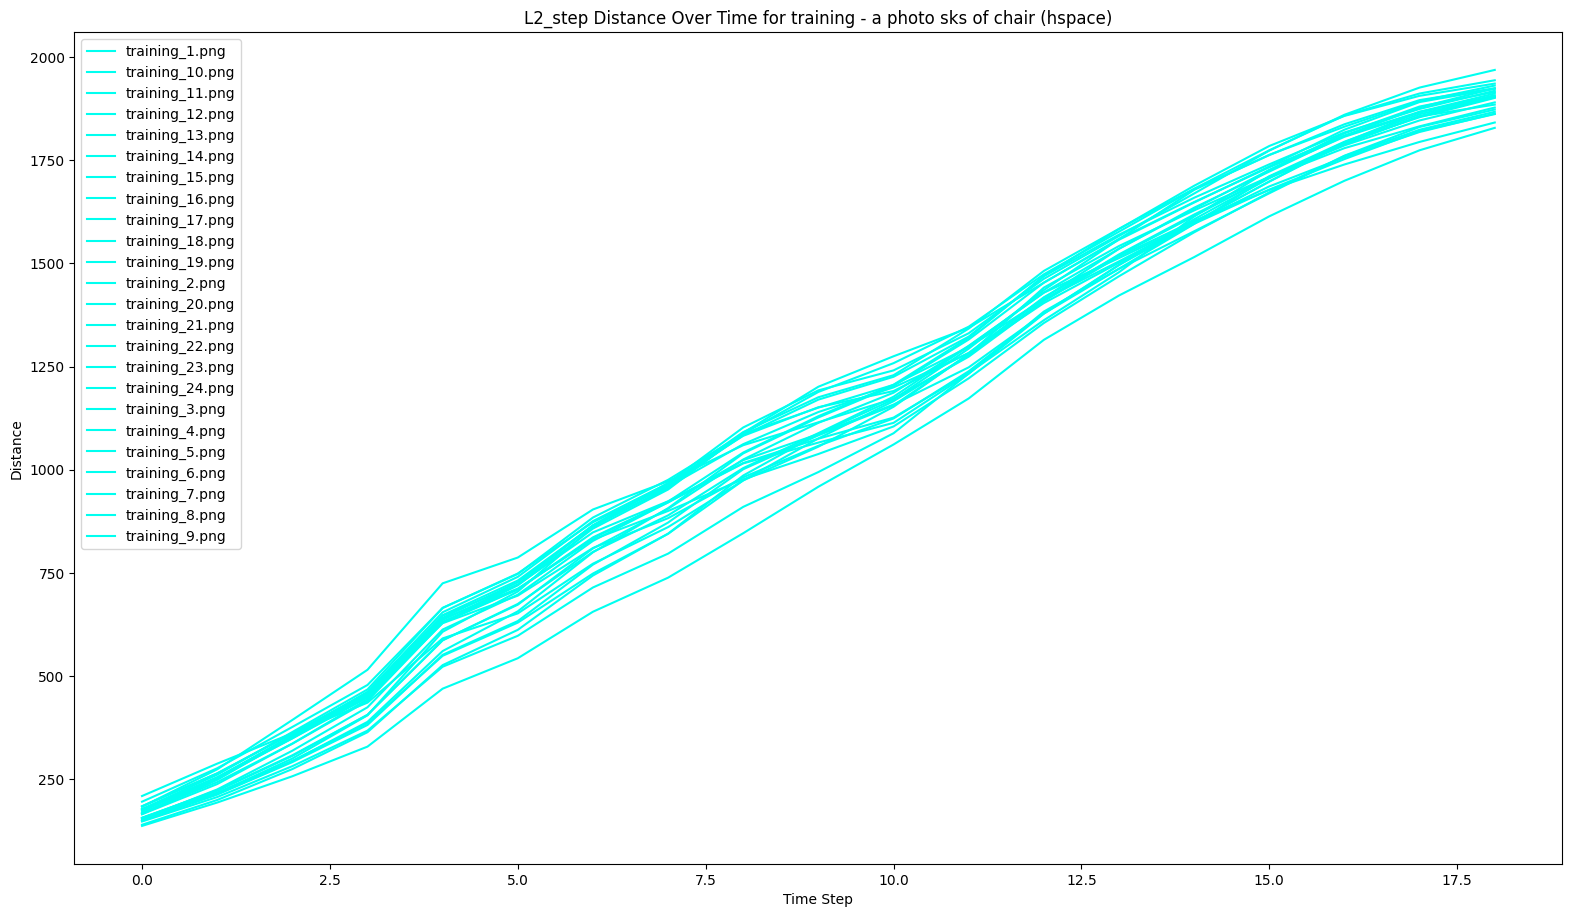

In [ ]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)

In [ ]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    keys = ['latent', 'image', 'hspace']
    
    # Color mapping by base and feature type
    color_map = {
        'latent': {'lora': '#FF9999', 'nolora': '#99CCFF'},
        'image': {'lora': '#99FF99', 'nolora': '#66CC66'},
        'hspace': {'lora': '#9999FF', 'nolora': '#6666CC'}
    }
    
    for base in analysis_data:
        for prefix in analysis_data[base]:
            for prompt in analysis_data[base][prefix]:
                for key in keys:
                    try:
                        # Collect all time series data
                        all_time_series = []
                        for image_name in analysis_data[base][prefix][prompt]:
                            data = analysis_data[base][prefix][prompt][image_name].get(key, [])
                            if isinstance(data, list) and len(data) > 0:
                                all_time_series.append(data)
                    
                        if not all_time_series:
                            print(f"No data found for {base}/{prefix}/{prompt}/{key}")
                            continue
                        
                        # Determine number of time steps
                        num_times = len(all_time_series[0])
                        
                        # Reorganize data by time step
                        data_by_time = [[] for _ in range(num_times)]
                        for series in all_time_series:
                            for t, value in enumerate(series[:num_times]):
                                data_by_time[t].append(value)
                        
                        # Create plot
                        plt.figure(figsize=(12, 8))
                        box = plt.boxplot(data_by_time, patch_artist=True, 
                                        boxprops=dict(facecolor=color_map[key][base]))
                        
                        # Calculate average and set properties
                        avg_distance = np.mean([np.mean(d) for d in data_by_time if d])
                        plt.ylabel('Distance')
                        plt.xlabel('Time Step')
                        plt.title(f'{key.capitalize()} Distance Over Time for {base}, {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                        plt.xticks(range(1, len(data_by_time) + 1), range(len(data_by_time)))
                        plt.legend([f"{base} {key}"])
                        
                        # Set median lines to black
                        for median in box['medians']:
                            median.set_color('black')
                        
                        plt.grid(True, linestyle='--', alpha=0.5)
                        plt.tight_layout()
                        plt.show()
                        
                    except Exception as e:
                        print(f"Error plotting {base}/{prefix}/{prompt}/{key}: {e}")

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_key_boxplots_by_base_prefix(analysis_data):
    keys = ['latent', 'image', 'hspace']
    
    # Define color scheme based on base and prefix combinations
    color_map = {
        'lora': {
            'noLoRA_Trigger': '#FF6B6B',  # Coral Red
            'LoRA_Trigger': '#FF8787',    # Light Coral
            'training': '#FF9E9E'         # Soft Coral
        },
        'nolora': {
            'noLoRA_Trigger': '#6BCBFF',  # Sky Blue
            'LoRA_Trigger': '#87D4FF',    # Light Sky Blue
            'training': '#9EDCFF'         # Soft Sky Blue
        }
    }

    for key in keys:
        base_prefix_time_data = {}
        max_timesteps = 0
        
        # Collect data by base, prefix and time step
        for base in analysis_data:
            for prefix in analysis_data[base]:
                base_prefix_key = f"{base}_{prefix}"
                base_prefix_time_data[base_prefix_key] = []
                
                for prompt in analysis_data[base][prefix]:
                    for image_name in analysis_data[base][prefix][prompt]:
                        data = analysis_data[base][prefix][prompt][image_name].get(key, [])
                        if len(data) == 0:
                            continue
                            
                        # Initialize time arrays if needed
                        while len(base_prefix_time_data[base_prefix_key]) < len(data):
                            base_prefix_time_data[base_prefix_key].append([])
                            
                        # Add data
                        for t, v in enumerate(data):
                            base_prefix_time_data[base_prefix_key][t].append(v)
                            
                        max_timesteps = max(max_timesteps, len(data))

        if not base_prefix_time_data:
            print(f"No data found for key: {key}")
            continue

        # Create plot
        plt.figure(figsize=(max(12, max_timesteps * 1.5), 8))
        positions = []
        data = []
        colors = []
        ticks = []
        labels = []

        # Calculate positions and prepare data for boxplots
        for t in range(max_timesteps):
            counter = 0
            for base_prefix in base_prefix_time_data:
                base, prefix = base_prefix.split('_', 1)
                if t < len(base_prefix_time_data[base_prefix]):
                    values = base_prefix_time_data[base_prefix][t]
                    if len(values) > 0:
                        data.append(values)
                        position = t * (len(base_prefix_time_data) + 1) + counter
                        positions.append(position)
                        colors.append(color_map[base][prefix])
                        labels.append(f"{base}_{prefix}")
                        counter += 1
            ticks.append(t * (len(base_prefix_time_data) + 1) + len(base_prefix_time_data) // 2)

        # Create boxplot
        box = plt.boxplot(data, positions=positions, patch_artist=True)

        # Set colors for boxes
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        # Set median line color
        for median in box['medians']:
            median.set_color('black')

        plt.xticks(ticks, [f"t={i}" for i in range(max_timesteps)], rotation=45)
        plt.title(f"{key.capitalize()} Distance Distribution by Time Step")
        plt.xlabel("Time Step")
        plt.ylabel("Distance")
        
        # Create legend with unique entries
        unique_base_prefixes = sorted(set(labels))
        legend_handles = []
        legend_labels = []
        for base_prefix in unique_base_prefixes:
            base, prefix = base_prefix.split('_', 1)
            legend_handles.append(plt.Line2D([0], [0], color=color_map[base][prefix], lw=10))
            legend_labels.append(f"{base}, {prefix}")
        
        plt.legend(
            legend_handles,
            legend_labels,
            title="Base, Prefix",
            loc="upper right"
        )
        
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Print average distances
        print(f"\nAverage distances for key: {key}")
        for base_prefix in base_prefix_time_data:
            base, prefix = base_prefix.split('_', 1)
            all_values = []
            for t_values in base_prefix_time_data[base_prefix]:
                all_values.extend(t_values)
            if all_values:
                avg = np.mean(all_values)
                print(f"- {base}, {prefix}: {avg:.4f}")
            else:
                print(f"- {base}, {prefix}: no data")

# Example usage
plot_key_boxplots_by_base_prefix(l2_analysis_data)

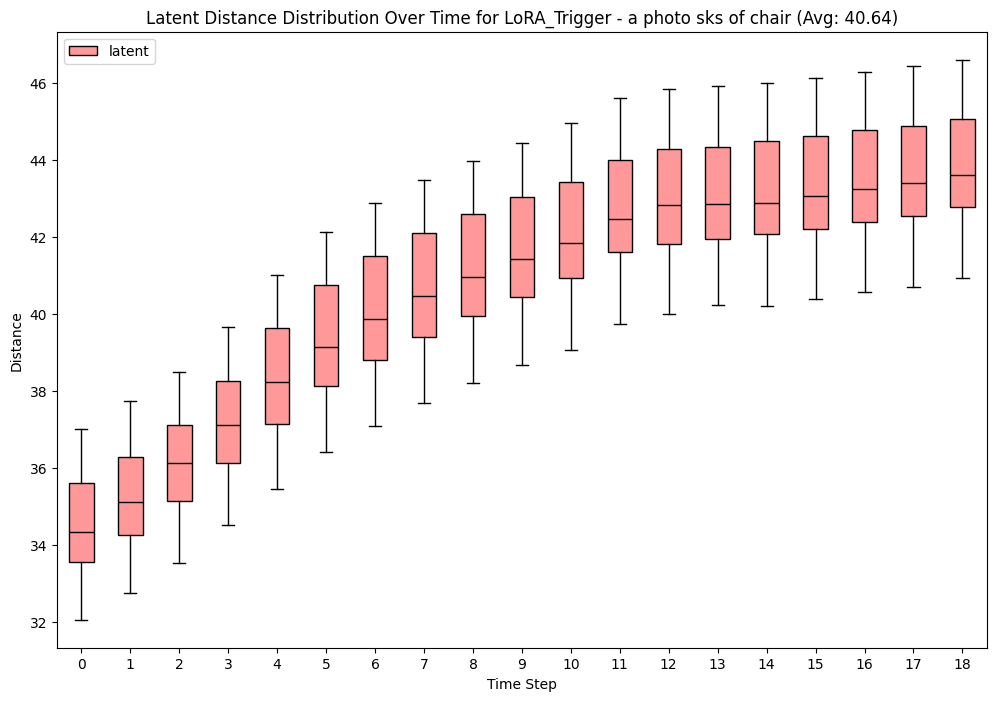

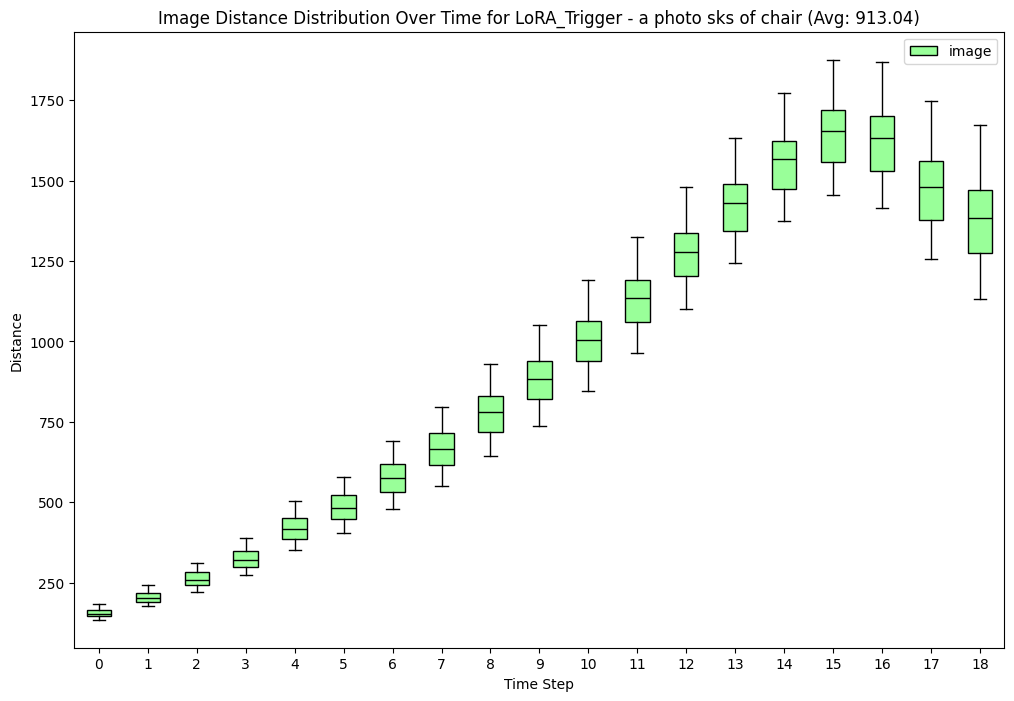

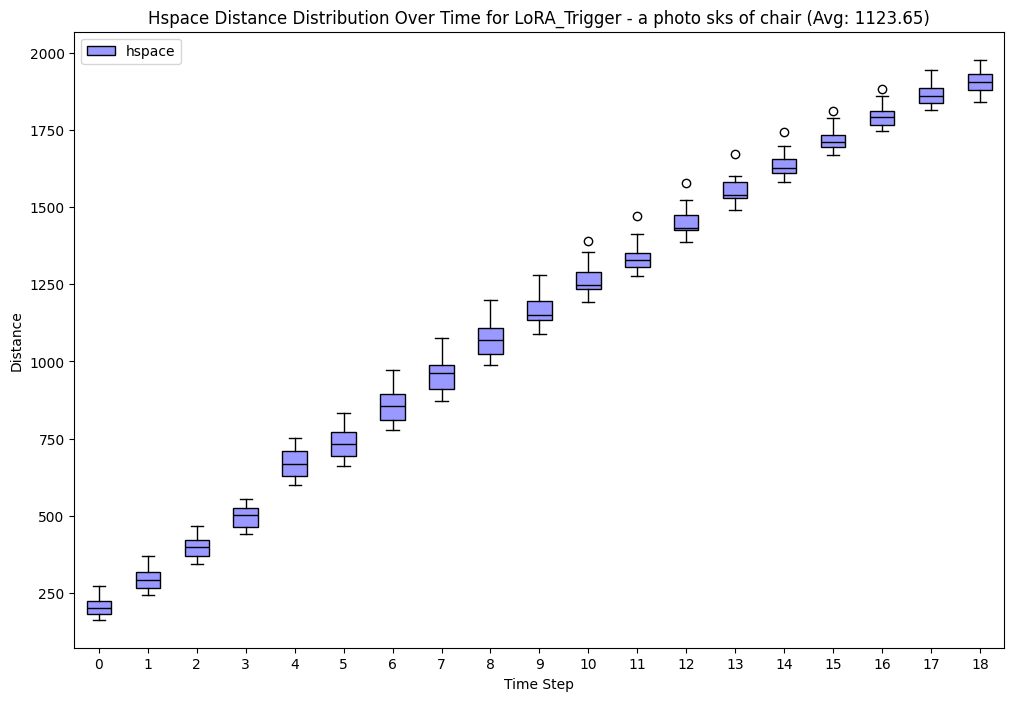

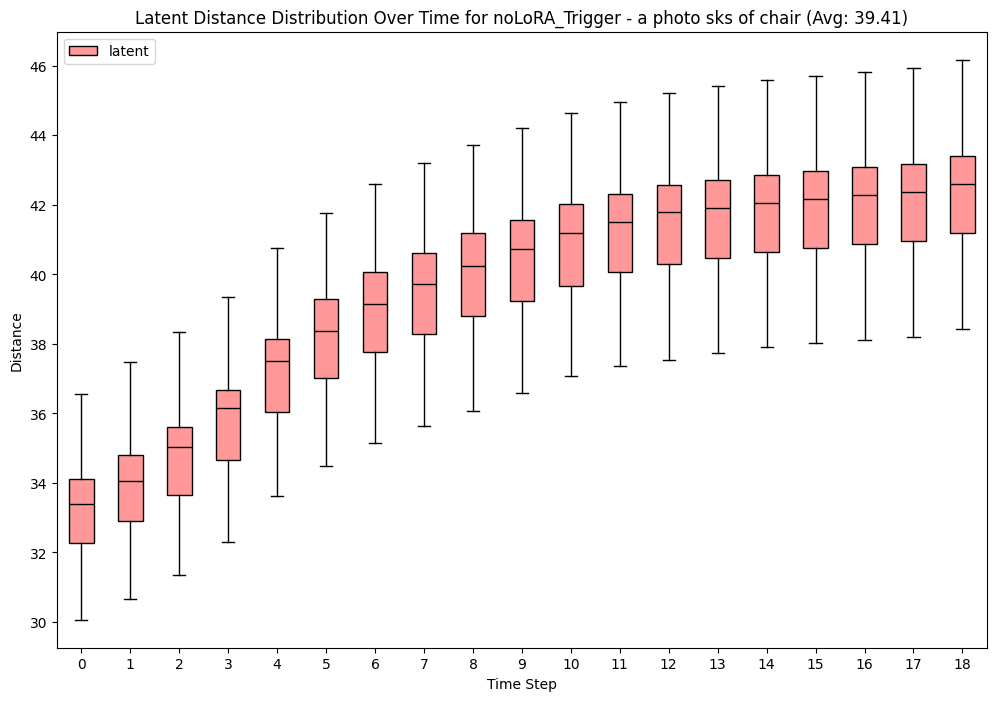

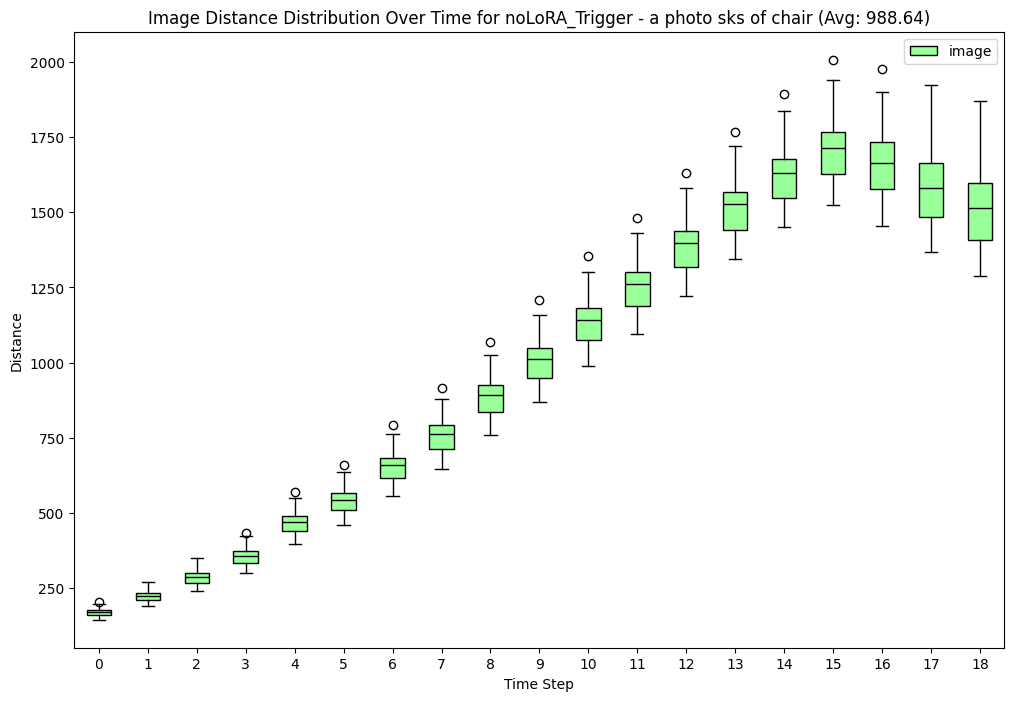

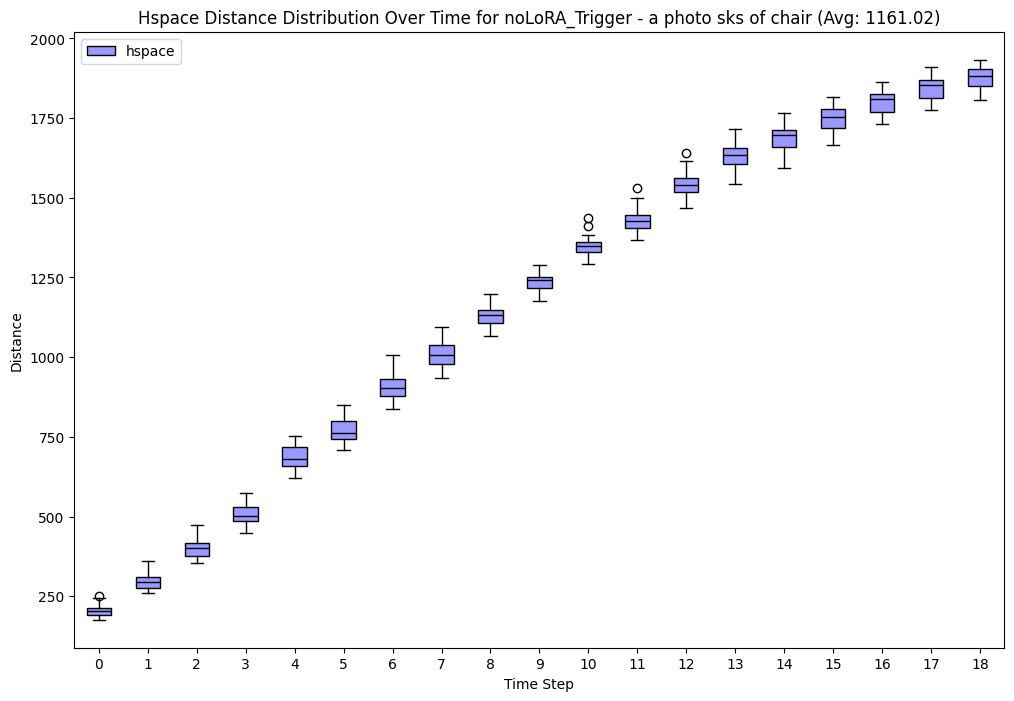

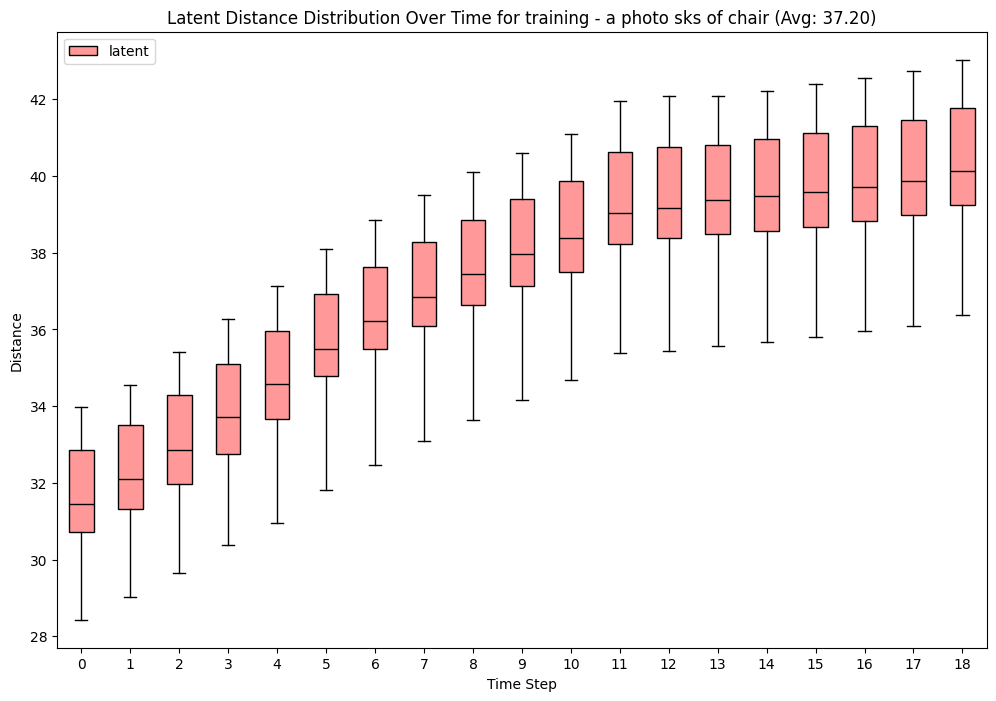

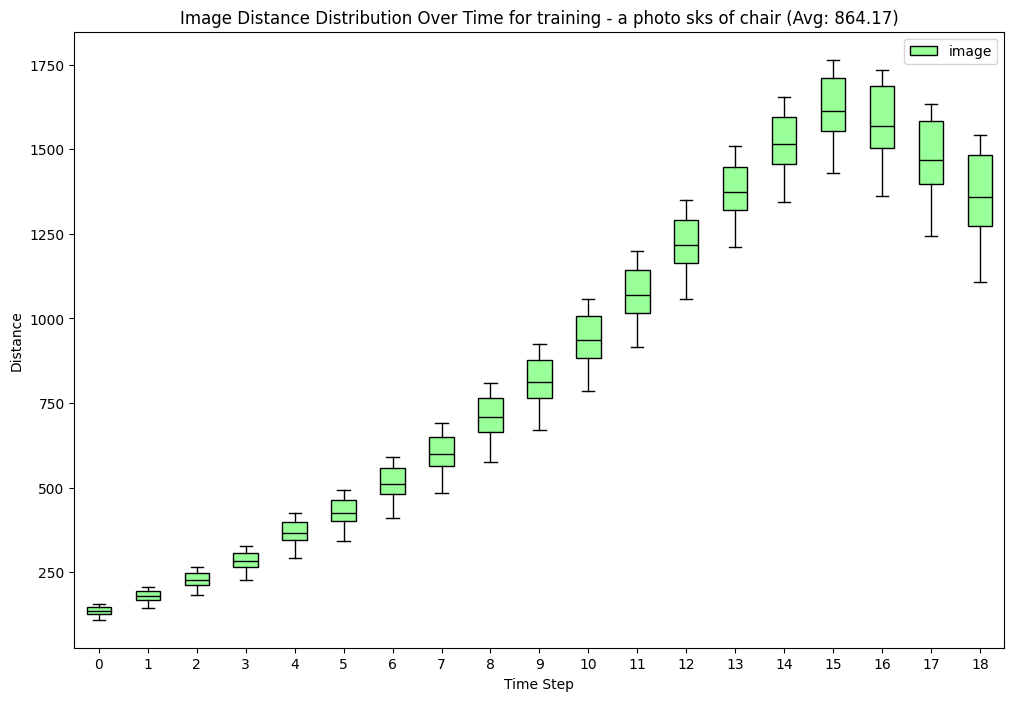

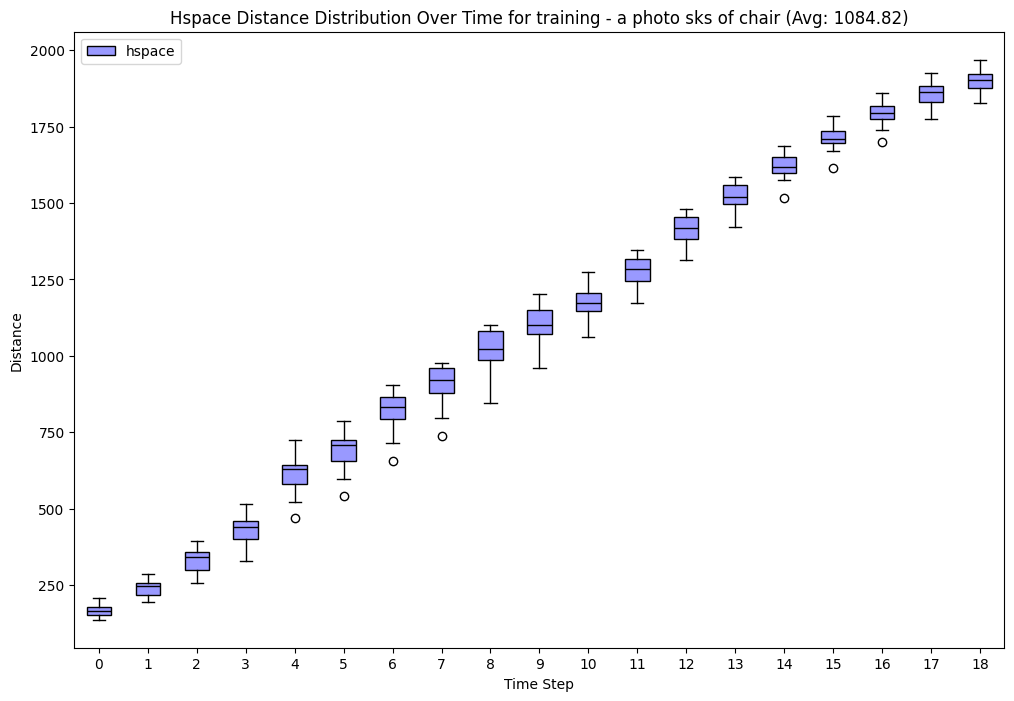

In [ ]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    colors = {'latent': '#FF9999', 'image': '#99FF99', 'hspace': '#9999FF'}
    
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for key in ["latent", "image", "hspace"]:
                try:
                    # Collect all time series data
                    all_time_series = []
                    for image_name in analysis_data[prefix][prompt].keys():
                        data = analysis_data[prefix][prompt][image_name][key]
                        if isinstance(data, list) and len(data) > 0:
                            all_time_series.append(data)
                
                    if not all_time_series:
                        print(f"No data found for {prefix}/{prompt}/{key}")
                        continue
                    
                    # Determine number of time steps
                    num_times = len(all_time_series[0])
                    
                    # Reorganize data by time step
                    data_by_time = [[] for _ in range(num_times)]
                    for series in all_time_series:
                        for t, value in enumerate(series[:num_times]):
                            data_by_time[t].append(value)
                    
                    # Create plot
                    plt.figure(figsize=(12, 8))
                    box = plt.boxplot(data_by_time, patch_artist=True, 
                                    boxprops=dict(facecolor=colors[key]))
                    
                    # Calculate average and set properties
                    avg_distance = np.mean([np.mean(d) for d in data_by_time if d])
                    plt.ylabel('Distance')
                    plt.xlabel('Time Step')
                    plt.title(f'{key.capitalize()} Distance Distribution Over Time for {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                    plt.xticks(range(1, len(data_by_time) + 1), range(len(data_by_time)))
                    plt.legend([key])
                    
                    # Set median lines to black
                    for median in box['medians']:
                        median.set_color('black')
                    
                    plt.show()
                    
                except Exception as e:
                    print(f"Error plotting {prefix}/{prompt}/{key}: {e}")

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)


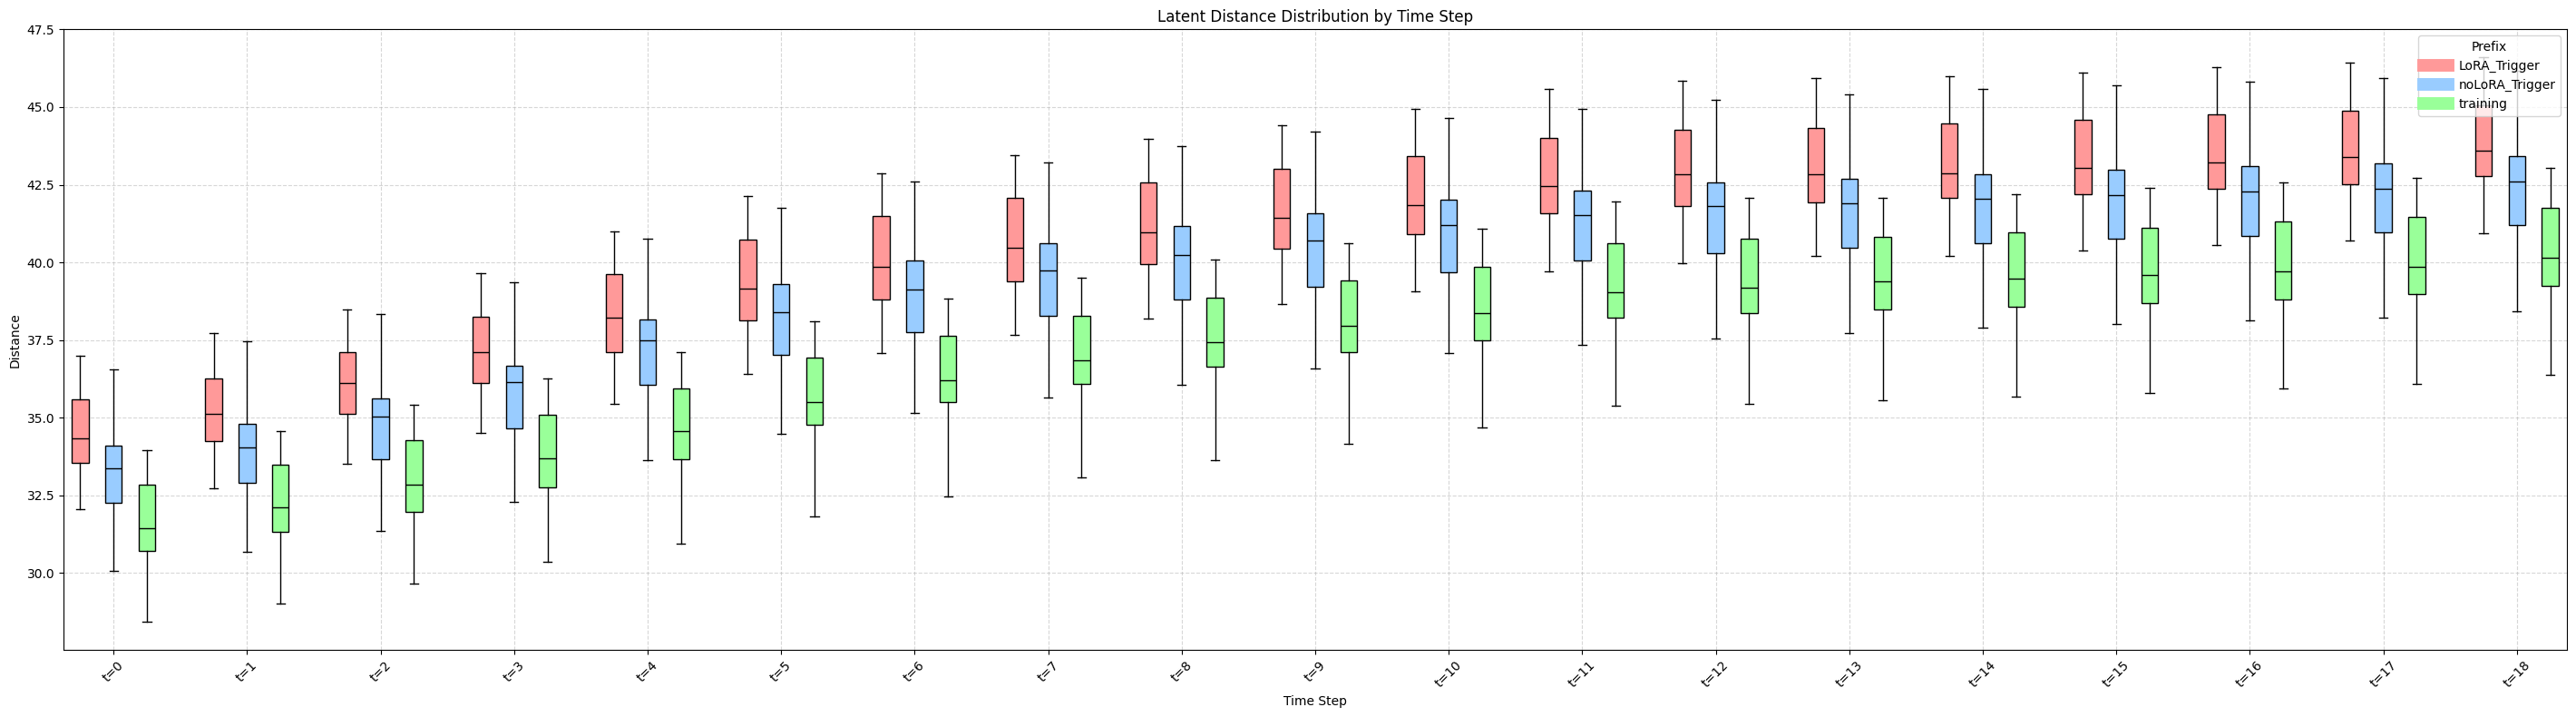


Average distances for key: latent
- LoRA_Trigger: 40.6444
- noLoRA_Trigger: 39.4096
- training: 37.1990


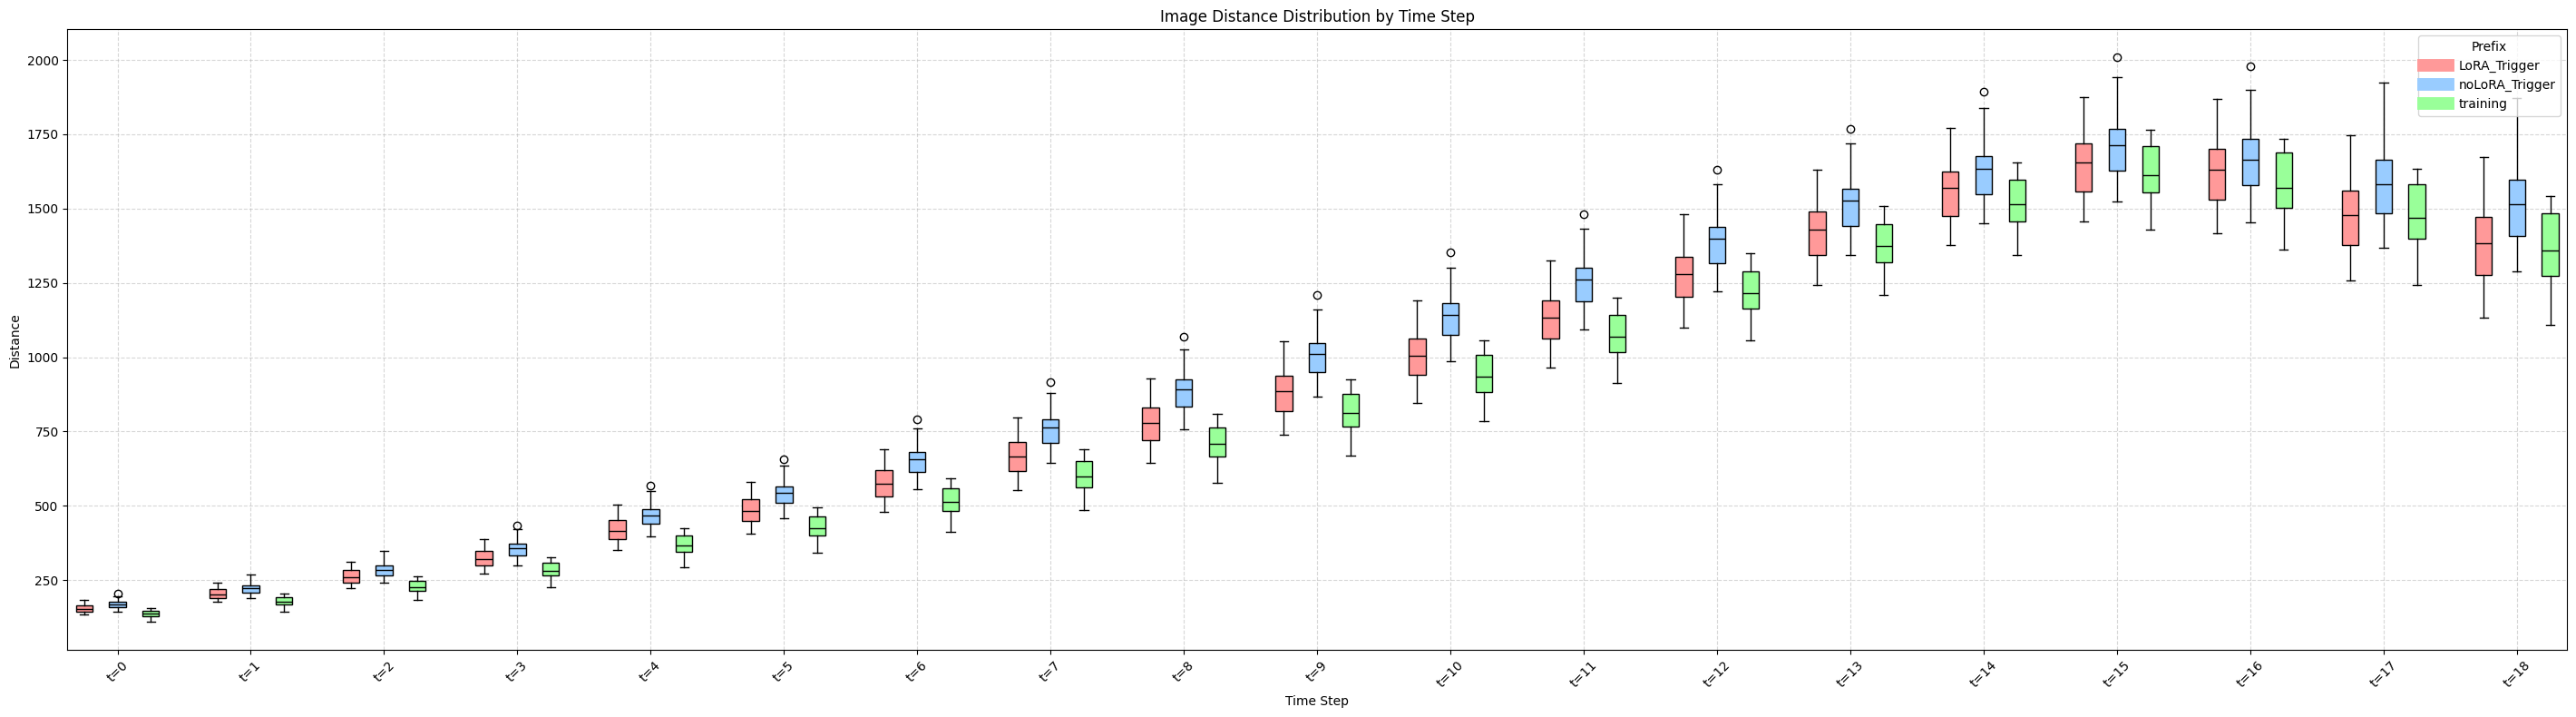


Average distances for key: image
- LoRA_Trigger: 913.0419
- noLoRA_Trigger: 988.6426
- training: 864.1652


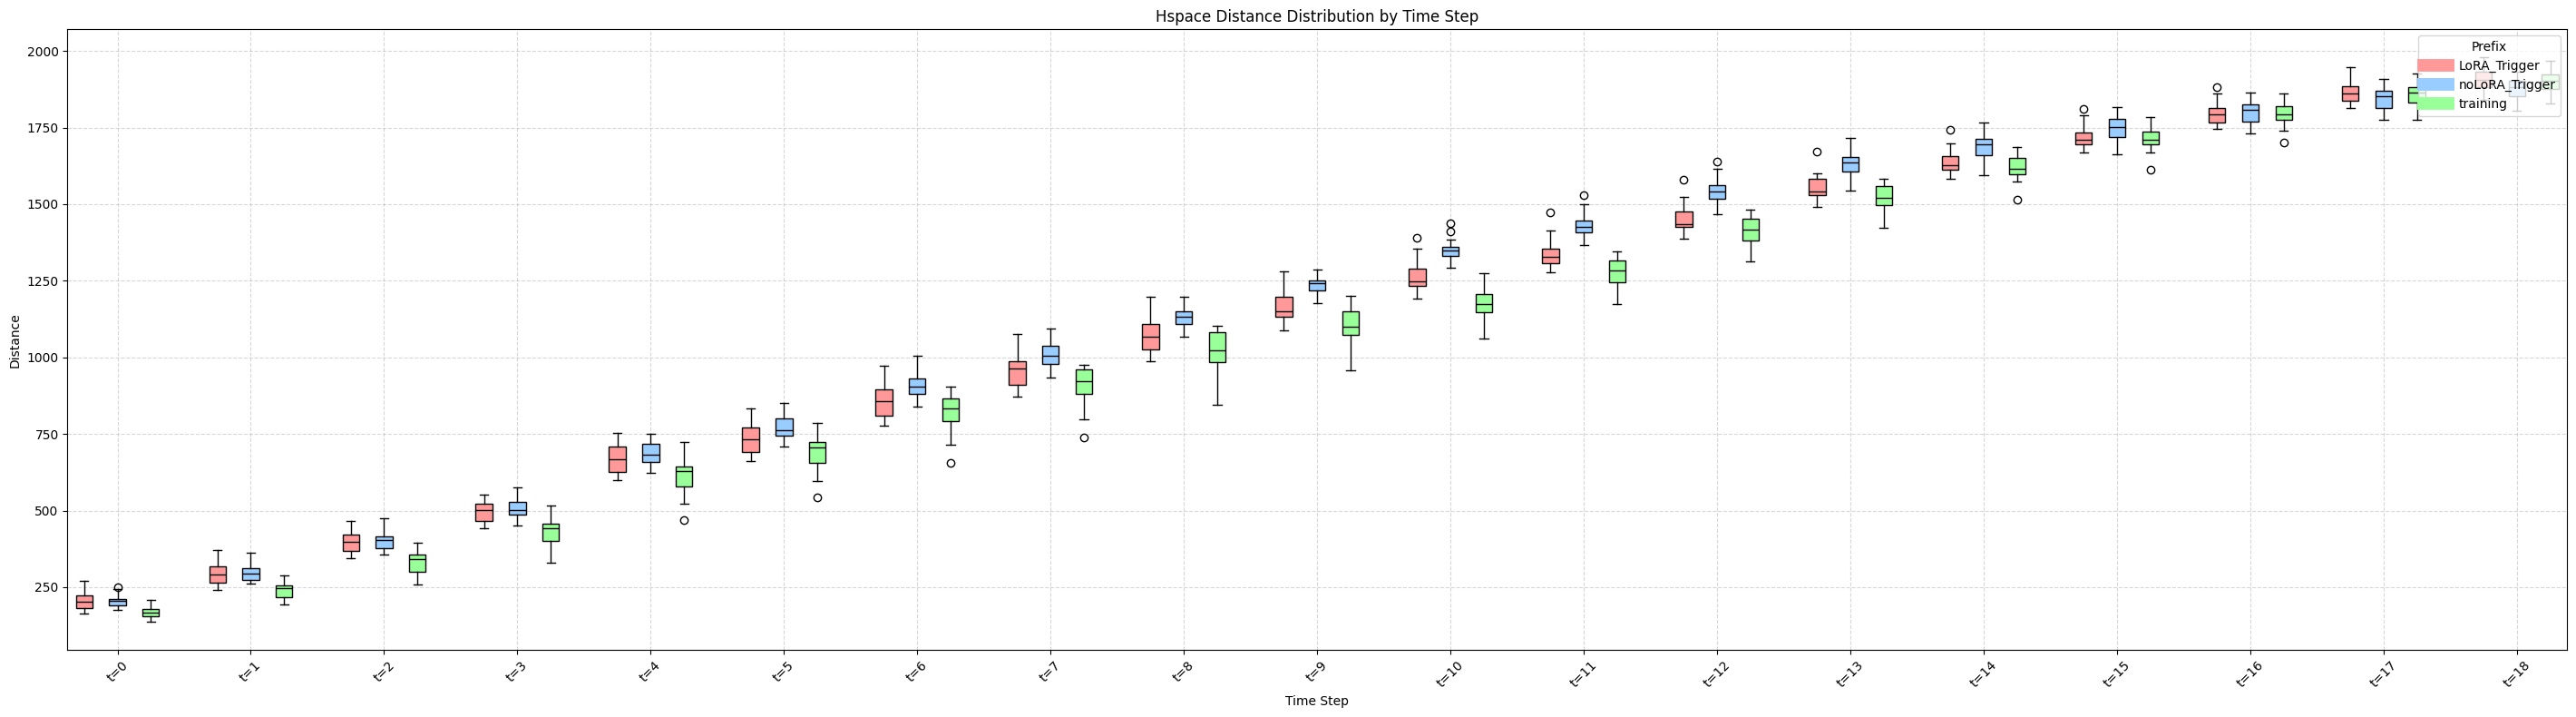


Average distances for key: hspace
- LoRA_Trigger: 1123.6503
- noLoRA_Trigger: 1161.0216
- training: 1084.8159


In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_key_boxplots_by_prefix(analysis_data):
    keys = ['latent', 'image', 'hspace']
    color_palette = ['#FF9999', '#99CCFF', '#99FF99', '#FFCC99', '#CC99FF', '#FFFF99', '#FFB6C1', '#87CEFA']
    prefix_colors = {}

    for key in keys:
        prefix_time_data = {}
        max_timesteps = 0

        for prefix_idx, prefix in enumerate(analysis_data):
            prefix_colors[prefix] = color_palette[prefix_idx % len(color_palette)]
            for prompt in analysis_data[prefix]:
                for image_name in analysis_data[prefix][prompt]:
                    data = analysis_data[prefix][prompt][image_name].get(key, [])
                    if len(data) == 0:
                        continue
                    if prefix not in prefix_time_data:
                        prefix_time_data[prefix] = [[] for _ in range(len(data))]
                    while len(prefix_time_data[prefix]) < len(data):
                        prefix_time_data[prefix].append([])  # 補空
                    for t, v in enumerate(data):
                        prefix_time_data[prefix][t].append(v)
                    max_timesteps = max(max_timesteps, len(data))

        if not prefix_time_data:
            print(f"No data found for key: {key}")
            continue

        # 畫圖
        plt.figure(figsize=(max(12, max_timesteps * 1.5), 8))
        positions = []
        data = []
        colors = []
        ticks = []

        for t in range(max_timesteps):
            for i, prefix in enumerate(prefix_time_data):
                if t < len(prefix_time_data[prefix]):
                    values = prefix_time_data[prefix][t]
                    if len(values) > 0:
                        data.append(values)
                        position = t * (len(prefix_time_data) + 1) + i
                        positions.append(position)
                        colors.append(prefix_colors[prefix])
            ticks.append(t * (len(prefix_time_data) + 1) + len(prefix_time_data) // 2)

        box = plt.boxplot(data, positions=positions, patch_artist=True)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        for median in box['medians']:
            median.set_color('black')

        plt.xticks(ticks, [f"t={i}" for i in range(max_timesteps)], rotation=45)
        plt.title(f"{key.capitalize()} Distance Distribution by Time Step")
        plt.xlabel("Time Step")
        plt.ylabel("Distance")
        plt.legend(
            [plt.Line2D([0], [0], color=prefix_colors[p], lw=10) for p in prefix_time_data],
            [p for p in prefix_time_data],
            title="Prefix",
            loc="upper right"
        )
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # === 新增：平均值輸出 ===
        print(f"\nAverage distances for key: {key}")
        for prefix in prefix_time_data:
            all_values = []
            for t_values in prefix_time_data[prefix]:
                all_values.extend(t_values)
            if all_values:
                avg = np.mean(all_values)
                print(f"- {prefix}: {avg:.4f}")
            else:
                print(f"- {prefix}: no data")
plot_key_boxplots_by_prefix(l2_analysis_data)
